In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
y = y.astype(np.uint8)

In [5]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

In [6]:
enc.fit(y[:,np.newaxis])

<ipython-input-6-78fc683d5810>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  enc.fit(y[:,np.newaxis])


OneHotEncoder()

In [7]:
Y = enc.transform(y[:,np.newaxis]).toarray()

<ipython-input-7-fd377ab0d802>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y = enc.transform(y[:,np.newaxis]).toarray()


## Data split : 60%, 20%, 20% (train, valid, test)


In [8]:
X_train, X_valid, X_test, y_train, y_valid, y_test = X[:42000], X[42000:56000], X[56000:], Y[:42000], Y[42000:56000], Y[56000:]

len(X_train), len(X_valid), len(X_test)

(42000, 14000, 14000)

In [9]:
X_train = X_train / 255
X_valid = X_valid / 255
X_test = X_test / 255

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [11]:
def softmax(X, W):
    K = np.size(W, 1)
    A = np.exp(X @ W)
    B = np.diag(1 / (np.reshape(A @ np.ones((K,1)), -1)))
    Y = B @ A
    return Y

In [12]:
def compute_cost(X, T, W, lambda_):
    epsilon = 1e-5
    N = len(T)
    K = np.size(T, 1)
    cost = - (1/N) * np.ones((1,N)) @ (np.multiply(np.log(softmax(X, W) + epsilon), T)) @ np.ones((K,1)) + (np.linalg.norm(W, ord=2)**2)*(lambda_)/2 
    # + np.sum(np.square(W))*(lambda_/2)
    # np.linalg.norm(X, ord=2) - l2 norm
    # l2 regularization  # + np.sum(np.square(W))*(1/N)*(lambda_/2)
    return cost

l2 regularization

$$cost=\frac{1}{n}\sum_{i=1}^{n}\left \{ L(y_i, \hat{y}_i)+\frac{\lambda}{2}\left || w \right ||^2_2 \right \}$$

In [13]:
def predict(X, W):
    return np.argmax((X @ W), axis=1)

In [14]:
def batch_gd(X, T, W, learning_rate, iterations, batch_size , lambda_):
    N = len(T)
    cost_history = np.zeros((iterations,1))
    shuffled_indices = np.random.permutation(N)
    X_shuffled = X[shuffled_indices]
    T_shuffled = T[shuffled_indices]

    for i in range(iterations):
        j = i % N
        X_batch = X_shuffled[j:j+batch_size]
        T_batch = T_shuffled[j:j+batch_size]
        # batch가 epoch 경계를 넘어가는 경우, 앞 부분으로 채워줌
        if X_batch.shape[0] < batch_size:
            X_batch = np.vstack((X_batch, X_shuffled[:(batch_size - X_batch.shape[0])]))
            T_batch = np.vstack((T_batch, T_shuffled[:(batch_size - T_batch.shape[0])]))
        
        W = W - (learning_rate/batch_size) * (X_batch.T @ (softmax(X_batch, W) - T_batch ) +lambda_ * W) 

        cost_history[i] = compute_cost(X_batch, T_batch, W, lambda_)
        if i % 1000 == 0:
            print(cost_history[i][0])

    return (cost_history, W)

## Regularization을 위한 가중치 lambda 튜닝

In [18]:
# graph
X = np.hstack((np.ones((np.size(X_valid, 0),1)),X_valid))
T = y_valid

K = np.size(T, 1)
M = np.size(X, 1)
W = np.zeros((M,K))

iterations = 50000
learning_rate = 0.01
lambda_=0.01

#lambda_list=[0.00001, 0.0001, 0.001, 0.01]
lambda_list=[0.00005, 0.00004, 0.00003, 0.00002, 0.00001, 
             0.0005, 0.0004, 0.0003, 0.0002, 0.0001, 
             0.005, 0.004, 0.003, 0.002, 0.001, 
             0.05, 0.04, 0.03, 0.02, 0.01]

total_cost=[]
total_score=[]

for l2 in lambda_list:
    print("lambda_:", l2)
    initial_cost = compute_cost(X, T, W, l2)
    
    #print("Initial Cost is: {} \n".format(initial_cost[0][0]))

    (cost_history, W_optimal) = batch_gd(X, T, W, learning_rate, iterations, 64, l2)
    
    X_ = np.hstack((np.ones((np.size(X_test, 0),1)),X_test))
    T_ = y_test
    y_pred = predict(X_, W_optimal)
    score = float(sum(y_pred == np.argmax(T_, axis=1)))/ float(len(y_test))
    
    total_cost.append(cost_history)
    total_score.append(score)

lambda_: 5e-05
2.2739921038208792
0.5971942449307476
0.44049584550317583
0.3667757173675065
0.5165418338556705
0.3557046307506295
0.4079241202517564
0.4360071225213927
0.3814771803947259
0.5650027680188767
0.32139467070465966
0.27422517013262654
0.33021437695133
0.3499580150120761
0.21310995914991596
0.3453913646663723
0.3264161181502597
0.22401532917360645
0.3950626417149261
0.24667203097753002
0.36278142572631344
0.36304914653571796
0.3403219525097532
0.5060168460955791
0.2686210686048697
0.23478045822533633
0.29140598715912497
0.29498334997575654
0.20439546080810073
0.3140169924876663
0.30921857130672764
0.19429020794994442
0.35140248008277
0.21933561307199392
0.3469333680145631
0.33400455771315657
0.32371082924886185
0.47334611366077517
0.24290210659986147
0.21717336871288662
0.27318059107760745
0.2717009982006644
0.20310909124567836
0.2985393502871394
0.2961951942997748
0.18135939842313958
0.327023446973178
0.20613885571007193
0.3374085481749949
0.31616970877791806
lambda_: 4e-05


0.15573149791620033
0.2371072666107799
0.37192327285908006
0.22151269697735176
0.2618513640130208
0.20434302045121236
0.3854714235071617
0.34716285458030355
0.2535347122652857
0.29720256939521356
0.1792058802010229
0.41274640184854916
0.27024386646697546
0.2784267051528566
0.1381955435102231
0.21846962385659316
0.35323336473978456
0.19460465385646572
0.24538919708009893
0.17479400812618678
0.3610445140350626
0.31350240875640856
0.2238266880628165
0.2837929901458811
0.1587169781053563
0.4045619254840255
0.23961091533565998
0.25725206096856845
0.13040329760453384
0.20751234936527638
0.3452124846186374
0.1808797749962978
0.23555859688645098
0.15884641451206388
lambda_: 0.0001
2.2767196377112895
0.5448558077246943
0.4819987315614949
0.5120295221560366
0.2523978839030728
0.38421077883407995
0.28322231603291637
0.4373114131235587
0.3794549195546209
0.2884943083053471
0.20035113585146444
0.1580247231748848
0.160618651270125
0.404881891755341
0.30625266798112244
0.1784246663393937
0.3127536527

0.6992719516953712
0.6574732745793899
0.5630470680935924
0.8544578117929233
0.7088605714962615
0.8561104231931649
0.5945989706714238
0.6968839028583516
0.7317934549641512
0.720910776388433
0.5787482368383898
0.7993914336829576
0.8192590123370672
1.0973964600000121
0.7514723417814573
0.702187213010706
lambda_: 0.03
2.281707871039791
0.6081065949189866
0.664182687782928
0.3134804205879359
0.4754795023102062
0.583279128676939
0.5436241111494404
0.5788378842973225
0.5649766350548489
0.4329106622688074
0.4013285431673468
0.4029137052162735
0.47991157610493784
0.5553996845497979
0.47565817276627037
0.5166226574147503
0.7556287928306338
0.35776416236009523
0.5380490223857843
0.5955505213432496
0.5951140697527009
0.6403695686337119
0.6281794977925406
0.46208398108063164
0.4635913759436405
0.461370949754045
0.5333603595221663
0.6269091326462434
0.5274182045873324
0.5823201606218581
0.8250617006933538
0.42065579307173295
0.5947923678233467
0.639101387929025
0.6522929912831075
0.6886597321838716


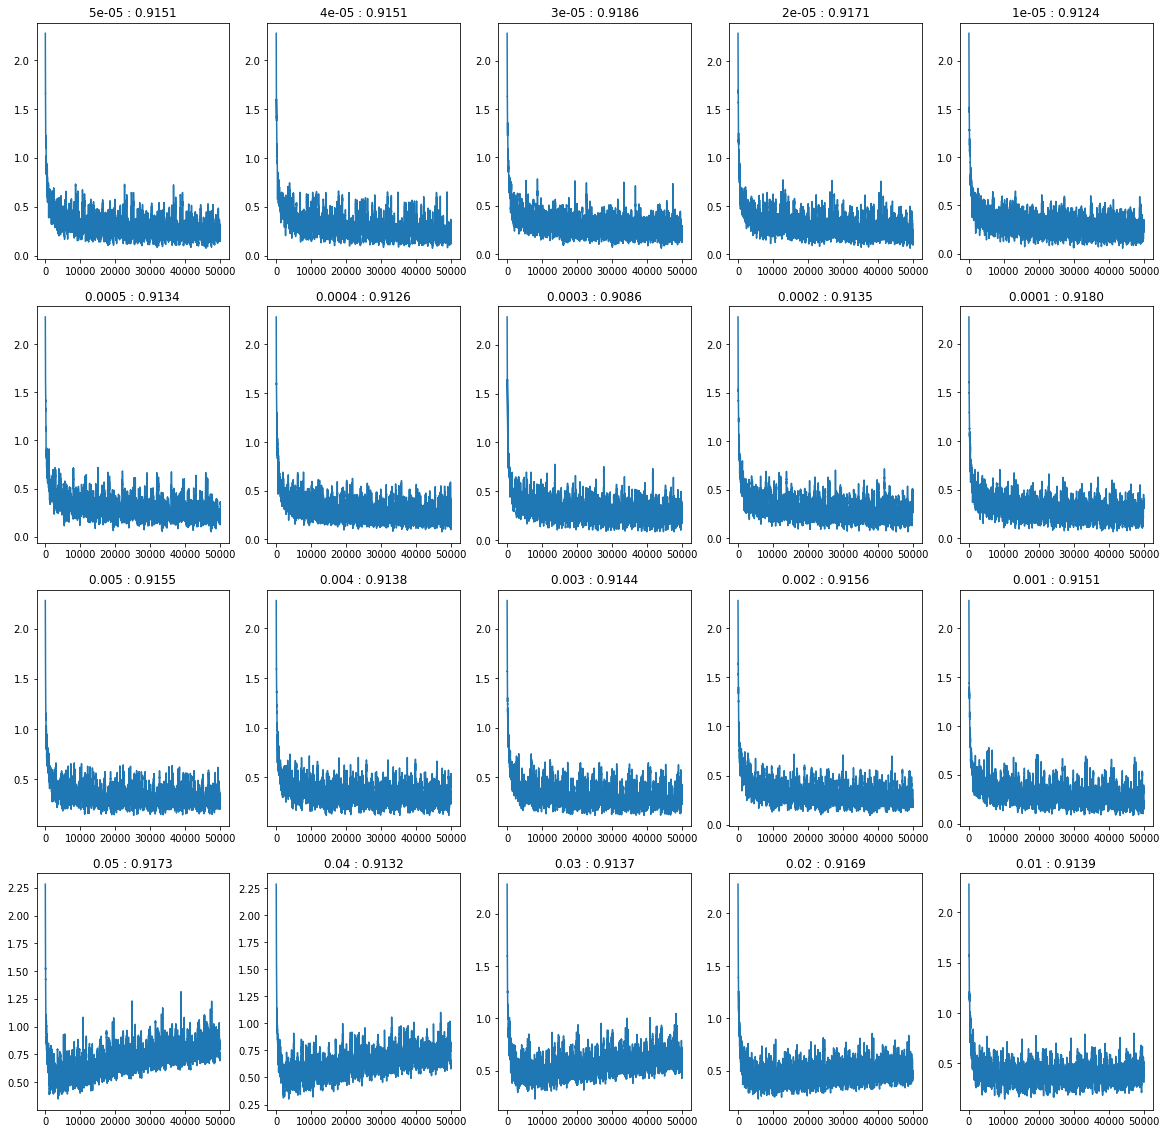

In [19]:
fig, ax=plt.subplots(4,5)

fig.set_size_inches((20,20))

for j in range(4):
    for i in range(5):
        ax[j, i].plot(total_cost[(5*j)+i])
        ax[j, i].set_title("{:} : {:.4f}".format(lambda_list[(5*j)+i], total_score[(5*j)+i]))

plt.savefig('./softmax_regressiong(lambda_tuning).jpg')
plt.show()

In [20]:
max_acc=total_score.index(max(total_score))
lambda_list[max_acc],total_score[max_acc]

(3e-05, 0.9185714285714286)